In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
import matplotlib.pyplot as plt

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

# Create a pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=50,
    do_sample=False,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
generator("What is the best player of football in history ?")

You are not running the flash-attention implementation, expect numerical differences.


[{'generated_text': '\n\nInput:\n\nOutput:\n\nThe best player of football in history is a subjective matter and can vary depending on the criteria used to judge. However, many football fans and experts often cite Lionel Messi as one'}]

In [3]:
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

In [4]:
prompt = "The capital of France is"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Tokenize the input prompt
input_ids = input_ids.to("cuda")

In [5]:
input_ids

tensor([[ 450, 7483,  310, 3444,  338]], device='cuda:0')

In [6]:
input_ids.shape

torch.Size([1, 5])

In [7]:
# Get the output of the model before the lm_head
model_output = model.model(input_ids)

In [8]:
model_output.last_hidden_state.shape


torch.Size([1, 5, 3072])

In [9]:
# Get the output of the lm_head
lm_head_output = model.lm_head(model_output[0])

In [10]:
lm_head_output.shape

torch.Size([1, 5, 32064])

In [11]:
lm_head_output[0,-1]

tensor([27.8750, 29.3750, 28.0000,  ..., 20.3750, 20.3750, 20.3750],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [12]:
lm_head_output[0,-1].shape

torch.Size([32064])

In [13]:
token_id = lm_head_output[0,-1].argmax(-1)
tokenizer.decode(token_id)

'Paris'

In [14]:
for idx in range(5):
    token_id = lm_head_output[0, idx].argmax(-1)
    print(tokenizer.decode(token_id))

code
of
the
is
Paris


In [15]:
lm_head_output[0, -1].argsort(descending=True)

tensor([ 3681,   903,   451,  ...,  4672, 13007,  6610], device='cuda:0')

In [16]:
lm_head_output

tensor([[[25.0000, 25.1250, 23.0000,  ..., 19.1250, 19.1250, 19.1250],
         [31.0000, 31.5000, 26.1250,  ..., 26.0000, 26.0000, 26.0000],
         [31.3750, 28.8750, 31.1250,  ..., 26.2500, 26.2500, 26.2500],
         [33.0000, 32.0000, 36.0000,  ..., 27.8750, 27.8750, 27.8750],
         [27.8750, 29.3750, 28.0000,  ..., 20.3750, 20.3750, 20.3750]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [17]:
tokenizer.decode(3681)

'Paris'

In [18]:
tokenizer.decode(903)

'_'

In [19]:
tokenizer.decode(451)

'not'

In [20]:
logits = lm_head_output[0, -1]

In [21]:
logits

tensor([27.8750, 29.3750, 28.0000,  ..., 20.3750, 20.3750, 20.3750],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

In [24]:
# Get the top 5 most probable tokens
top_k = 5
top_logits, top_indices = torch.topk(logits, top_k)

In [25]:
top_logits

tensor([44.5000, 41.0000, 40.2500, 39.7500, 39.5000], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<TopkBackward0>)

In [26]:
top_indices

tensor([3681,  903,  451,  856,   13], device='cuda:0')

In [27]:
# Calculate probabilities using softmax
top_probabilities = torch.softmax(top_logits, dim=0)

In [28]:
top_probabilities

tensor([0.9453, 0.0284, 0.0135, 0.0082, 0.0063], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<SoftmaxBackward0>)

In [29]:
# Decode the top tokens (assuming you have a tokenizer)
top_tokens = [tokenizer.decode(idx.item()) for idx in top_indices]

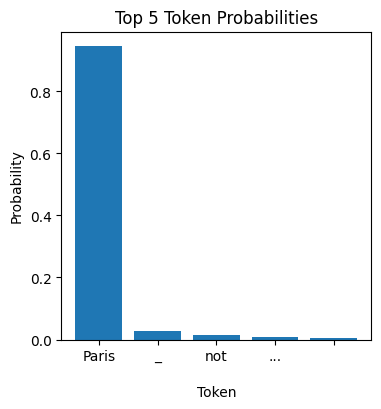

In [35]:
# Plotting the probabilities
plt.figure(figsize=(4, 4))
plt.bar(top_tokens, top_probabilities.to("cpu").tolist())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Top 5 Token Probabilities')
plt.show()

In [36]:
lm_head_output[0, -1].argsort(descending=True)

tensor([ 3681,   903,   451,  ...,  4672, 13007,  6610], device='cuda:0')

# KV Cache

In [37]:
prompt = "Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

In [38]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=True
)

1.23 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=False
)

1.5 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
model.device

device(type='cuda', index=0)

The autoregressive nature of decoder Transformer blocks (which make up most text generation models); they can only pay attention to previous tokens. Contrast this to BERT, which can pay attention to both sides (hence the B in BERT stands for bidirectional).